# PINN for flow around a cylinder
The Navier-Stokes equations are being solved for incompressible flow around a cylinder. These equations are a set of partial differential equations (PDEs) governing the motion of fluid substances. For a 2D incompressible, viscous flow, they can be written in the Cartesian coordinate system as follows:

## Continuity Equation:

The continuity equation represents the conservation of mass, stating that the mass entering a control volume must equal the mass exiting the volume, plus any change in mass within the volume. For an incompressible flow, it simplifies to:

$$ \nabla u = 0 $$

or, in a two-dimensional form:

$$
\begin{equation}
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0
\tag{1}
\end{equation}
$$

where u and v are the velocity components in the x and y directions respectively.

## Momentum Equations:

The momentum equations represent the conservation of momentum. They are the result of applying Newton's second law (force equals the rate of change of momentum) to fluid motion. The Navier-Stokes equations include the effects of viscosity, which are modeled with a Laplacian operator. The momentum equations for an incompressible flow can be written as:

$$
\begin{equation}
\rho \left( \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} \right) = -\frac{\partial p}{\partial x} + \nu \nabla^2 u
\tag{2}
\end{equation}
$$
$$
\begin{equation}
\rho \left( \frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} \right) = -\frac{\partial p}{\partial y} + \nu \nabla^2 v
\tag{3}
\end{equation}
$$

where:

ρ is the fluid density
u, v are the velocity components in the x and y directions, respectively
t is time
p is pressure
ν is the kinematic viscosity
∇² is the Laplacian operator, denoting the divergence of the gradient of a scalar field, here used to represent the diffusion of momentum (due to viscosity)
The pressure-Poisson equation is also used to enforce incompressibility:

$$
\begin{equation}
\nabla^2 p = -\rho \left[ \left( \frac{\partial (u^2)}{\partial x} + \frac{\partial (uv)}{\partial y} \right) + \left( \frac{\partial (uv)}{\partial x} + \frac{\partial (v^2)}{\partial y} \right) \right]
\tag{4}
\end{equation}
$$
where
$$
\nabla^2 p = \frac{\partial^2 p}{\partial x^2} + \frac{\partial^2 p}{\partial y^2}
$$

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

import math
import random

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"

In [2]:
xmax = 1.0
ymax = 1.0
tmax = 0.1

In [3]:
rho = 1
mu = .1

In [4]:
# Define the cylinder
center = [0.5, 0.5]  # center of the cylinder
radius = 0.1  # radius of the cylinder

In [5]:
def compute_grad(x, y):
        return torch.autograd.grad(x, y, grad_outputs=torch.ones_like(x), create_graph=True, retain_graph=True, only_inputs=True)[0]

In [6]:
def get_collocation_points(xmin, xmax, ymin, ymax, tmin, tmax, center, radius, n):
    
    x = []
    y = []
    t = []

    h, k = center  # center of the circle

    while len(x) < n:  # generate Nf points
        # Generate random point in the rectangle
        x_point = xmin + (xmax - xmin) * random.random()
        y_point = ymin + (ymax - ymin) * random.random()
        t_point = tmin + (tmax - tmin) * random.random()
        
        # Check if point is outside the circle
        if (x_point - h) ** 2 + (y_point - k) ** 2 >= radius ** 2:
            x.append(x_point)
            y.append(y_point)
            t.append(t_point)
    return x, y, t

def get_boundary_points(xmin, xmax, tmin, tmax, n):
    
    x = []
    t = []

    while len(x) < n:  # generate Nb points
    # Generate random point in the rectangle
        x_point = xmin + (xmax - xmin) * random.random()
        t_point = tmin + (tmax - tmin) * random.random()
        
        x.append(x_point)
        t.append(t_point)

    return x, t

def get_cylinder_bc_points(center, radius, tmin, tmax, n):

    x_center, y_center = center
    x = []
    y = []
    t = []
    
    for _ in range(n):
        # Generate random angle and random radius
        rand_angle = 2 * math.pi * random.random()
        rand_radius = radius * math.sqrt(random.random())
        # Convert polar coordinates to cartesian
        x_point = x_center + rand_radius * math.cos(rand_angle)
        y_point = y_center + rand_radius * math.sin(rand_angle)
        t_point = tmin + (tmax - tmin) * random.random()

        # Append to the lists
        x.append(x_point)
        y.append(y_point)
        t.append(t_point)

    return x, y, t

In [7]:
def get_batch(Nf, Nc, Nb):

    xf, yf, tf = get_collocation_points(0, xmax, 0, ymax, 0, tmax, center, radius, Nf)
    xc, yc, tc = get_cylinder_bc_points(center, radius, 0, tmax, Nc)

    xb_left = np.zeros(int(Nb/4))
    yb_left, tb_left = get_boundary_points(0, ymax, 0, tmax, int(Nb/4))

    xb_right = np.ones(int(Nb/4))
    yb_right, tb_right = get_boundary_points(0, ymax, 0, tmax, int(Nb/4))

    xb_up, tb_up = get_boundary_points(0, xmax, 0, tmax, int(Nb/4))
    yb_up = np.ones(int(Nb/4))

    xb_down, tb_down = get_boundary_points(0, xmax, 0, tmax, int(Nb/4))
    yb_down = np.zeros(int(Nb/4))

    # Convert numpy arrays to PyTorch tensors
    xf_tensor = torch.tensor(xf, dtype=torch.float32, device=device, requires_grad=True)
    yf_tensor = torch.tensor(yf, dtype=torch.float32, device=device, requires_grad=True)
    tf_tensor = torch.tensor(tf, dtype=torch.float32, device=device, requires_grad=True)

    xc_tensor = torch.tensor(xc, dtype=torch.float32, device=device, requires_grad=True)
    yc_tensor = torch.tensor(yc, dtype=torch.float32, device=device, requires_grad=True)
    tc_tensor = torch.tensor(tc, dtype=torch.float32, device=device, requires_grad=True)

    xb_left_tensor = torch.tensor(xb_left, dtype=torch.float32, device=device, requires_grad=True)
    yb_left_tensor = torch.tensor(yb_left, dtype=torch.float32, device=device, requires_grad=True)
    tb_left_tensor = torch.tensor(tb_left, dtype=torch.float32, device=device, requires_grad=True)

    xb_right_tensor = torch.tensor(xb_right, dtype=torch.float32, device=device, requires_grad=True)
    yb_right_tensor = torch.tensor(yb_right, dtype=torch.float32, device=device, requires_grad=True)
    tb_right_tensor = torch.tensor(tb_right, dtype=torch.float32, device=device, requires_grad=True)

    xb_up_tensor = torch.tensor(xb_up, dtype=torch.float32, device=device, requires_grad=True)
    yb_up_tensor = torch.tensor(yb_up, dtype=torch.float32, device=device, requires_grad=True)
    tb_up_tensor = torch.tensor(tb_up, dtype=torch.float32, device=device, requires_grad=True)

    xb_down_tensor = torch.tensor(xb_down, dtype=torch.float32, device=device, requires_grad=True)
    yb_down_tensor = torch.tensor(yb_down, dtype=torch.float32, device=device, requires_grad=True)
    tb_down_tensor = torch.tensor(tb_down, dtype=torch.float32, device=device, requires_grad=True)

    return xf_tensor, yf_tensor, tf_tensor, xc_tensor, yc_tensor, tc_tensor, xb_left_tensor, yb_left_tensor, tb_left_tensor, xb_right_tensor, yb_right_tensor, tb_right_tensor, xb_up_tensor, yb_up_tensor, tb_up_tensor, xb_down_tensor, yb_down_tensor, tb_down_tensor

In [8]:
Nf = 10000
Nc = 1000
Nb = 4000

In [9]:
import plotly.graph_objects as go

def plot_batch():

    xf, yf, tf, xc, yc, tc, xb_left, yb_left, tb_left, xb_right, yb_right, tb_right, xb_up, yb_up, tb_up, xb_down, yb_down, tb_down = map(lambda x: x.detach(), get_batch(Nf, Nc, Nb))

    xb = np.concatenate((xb_left.detach().numpy(), xb_right.detach().numpy(), xb_up.detach().numpy(), xb_down.detach().numpy()))
    yb = np.concatenate((yb_left.detach().numpy(), yb_right.detach().numpy(), yb_up.detach().numpy(), yb_down.detach().numpy()))
    tb = np.concatenate((tb_left.detach().numpy(), tb_right.detach().numpy(), tb_up.detach().numpy(), tb_down.detach().numpy()))

    fig1 = go.Figure(
        data = [
                go.Scatter3d(
                    x=xf,
                    y=tf,
                    z=yf,
                    mode='markers',
                    marker=dict(
                        size=2,
                        color="blue",
                        colorscale='Viridis',
                        opacity=0.8),
                    name="Collocation points",
                    showlegend=True)])

    fig2 = go.Figure(
        data = [
                go.Scatter3d(
                    x=xb,
                    y=tb,
                    z=yb,
                    mode='markers',
                    marker=dict(
                        size=2,
                        color="green",
                        colorscale='Viridis',
                        opacity=0.8),
                        name="Boundary points",
                        showlegend=True),
                go.Scatter3d(
                    x=xc,
                    y=tc,
                    z=yc,
                    mode='markers',
                    marker=dict(
                        size=2,
                        color="red",
                        colorscale='Viridis',
                        opacity=0.8),
                    name="Cylinder boundary points",
                    showlegend=True)])

    # Updating titles and labels
    for fig in [fig1, fig2]:
        fig.update_layout(
            scene=dict(
                xaxis_title='x',
                yaxis_title='t',
                zaxis_title='y'
            ),
            width=700,
            margin=dict(r=20, b=10, l=10, t=10))
        # Show the plot
        fig.show()

plot_batch()

In [10]:
import os
import pandas as pd
import numpy as np

def get_u_data(indices_to_extract, dir_path, Nt):

    # Dictionary to store the results
    result_dict = {}

    for time_step in range(Nt):
        file_path = dir_path + "/u_" + str(time_step) + ".csv"
        if os.path.exists(file_path):
            df = pd.read_csv(file_path, header=None)
            result_dict[file_path] = [df.iloc[i, j] for i, j in indices_to_extract]
        else: 
            print("error")
            exit()

    u_data = []

    for file_path, values in result_dict.items():
        u_data.append(values)

    return np.array(u_data)

def get_v_data(indices_to_extract, dir_path, Nt):

    # Dictionary to store the results
    result_dict = {}

    for time_step in range(Nt):
        file_path = dir_path + "/v_" + str(time_step) + ".csv"
        if os.path.exists(file_path):
            df = pd.read_csv(file_path, header=None)
            result_dict[file_path] = [df.iloc[i, j] for i, j in indices_to_extract]
        else: 
            print("error")
            exit()

    v_data = []

    for file_path, values in result_dict.items():
        v_data.append(values)

    return np.array(v_data)

def get_p_data(indices_to_extract, dir_path, Nt):

    # Dictionary to store the results
    result_dict = {}

    for time_step in range(Nt):
        file_path = dir_path + "/p_" + str(time_step) + ".csv"
        if os.path.exists(file_path):
            df = pd.read_csv(file_path, header=None)
            result_dict[file_path] = [df.iloc[i, j] for i, j in indices_to_extract]
        else: 
            print("error")
            exit()

    p_data = []

    for file_path, values in result_dict.items():
        p_data.append(values)

    return np.array(p_data)

def get_data_coords(data_indeces, dx, dy):

    coords = []

    for x_index, y_index in data_indeces:
        coords.append([x_index * dx, y_index * dy])

    return coords

def get_timestamps(Nt, dt):

    timestamps = []

    for timestep in range(Nt):
        timestamps.append(timestep * dt)

    return np.array(timestamps)

In [11]:
# Specified indices to extract
data_indeces = [(10, 50), (10, 10), (50, 50), (50, 10)] # 0-based

# Directory containing the CSV files
u_data_dir_path = 'C:/Users/gitop/repos/pinns/src/python/cylinder_flow_2d/csv_files/u'
v_data_dir_path = 'C:/Users/gitop/repos/pinns/src/python/cylinder_flow_2d/csv_files/v'
p_data_dir_path = 'C:/Users/gitop/repos/pinns/src/python/cylinder_flow_2d/csv_files/p'

# Number of timesteps
Nt = 1000

xmax = 1.0
ymax = 1.0
tmax = 0.1

Nx = 64
Ny = 64
Nt = 1000

dx = xmax / (Nx - 1)
dy = ymax / (Ny - 1)
dt = tmax / (Nt - 1)

def load_training_data():

    u_data = get_u_data(data_indeces, u_data_dir_path, Nt)
    v_data = get_v_data(data_indeces, v_data_dir_path, Nt)
    p_data = get_p_data(data_indeces, p_data_dir_path, Nt)

    data_coords = get_data_coords(data_indeces, dx, dy)
    timestamps = get_timestamps(Nt, dt)
    
    inputs = []

    for t in timestamps:
        for x, y in data_coords:
            inputs.append([x, y, t])

    inputs = np.array(inputs)

    outputs = []

    for t in range(Nt):
        for i in range(len(data_coords)):
            outputs.append([u_data[t, i], v_data[t, i], p_data[t, i]])

    outputs = np.array(outputs)

    return inputs, outputs

In [12]:
training_inputs, training_outputs = load_training_data()
xu, yu, tu = training_inputs[:, 0], training_inputs[:, 1], training_inputs[:, 2]
uu, vu, pu = training_outputs[:, 0], training_outputs[:, 1], training_outputs[:, 2]

xu = torch.tensor(xu, dtype=torch.float32, device=device, requires_grad=True)
yu = torch.tensor(yu, dtype=torch.float32, device=device, requires_grad=True)
tu = torch.tensor(tu, dtype=torch.float32, device=device, requires_grad=True)

uu = torch.tensor(uu, dtype=torch.float32, device=device, requires_grad=True)
vu = torch.tensor(vu, dtype=torch.float32, device=device, requires_grad=True)
pu = torch.tensor(pu, dtype=torch.float32, device=device, requires_grad=True)

In [13]:
import torch.nn.init as init

class PINN(nn.Module):

    def __init__(self, hidden_units):

        super(PINN, self).__init__()
        
        self.layers = nn.ModuleList()
        in_units = 3
        out_units = 3
        
        for units in hidden_units:
            layer = nn.Sequential(
                nn.Linear(in_units, units),
                nn.BatchNorm1d(units),
                nn.Tanh()
            )
            self.layers.append(layer)
            in_units = units

        output_layer = nn.Sequential(
            nn.Linear(in_units, out_units),
            nn.BatchNorm1d(out_units),
        )
        self.layers.append(output_layer)

        # Initialize layers with Xavier initialization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x, y, t):

        x = x.flatten()
        y = y.flatten()
        t = t.flatten()

        input = torch.stack([x, y, t], dim=-1)

        for layer in self.layers[:-1]:
            output = layer(input)
            input = output
        output = self.layers[-1](input)
        u = output[:, 0]
        v = output[:, 1]
        p = output[:, 2]

        return u, v, p

    def mse_f(self, x, y, t):

        u, v, p = self(x, y, t)

        # Compute derivatives of u
        u_t = compute_grad(u, t)
        u_x = compute_grad(u, x)
        u_y = compute_grad(u, y)
        u_xx = compute_grad(u_x, x)
        u_yy = compute_grad(u_y, y)

        # Compute derivatives of v
        v_t = compute_grad(v, t)
        v_x = compute_grad(v, x)
        v_y = compute_grad(v, y)
        v_xx = compute_grad(v_x, x)
        v_yy = compute_grad(v_y, y)

        # Compute derivatives of p
        p_x = compute_grad(p, x)
        p_xx = compute_grad(p_x, x)
        p_y = compute_grad(p, y)
        p_yy = compute_grad(p_y, y)

        # Compute additional derivatives
        u2_x = compute_grad(u**2, x)
        v2_y = compute_grad(v**2, y)
        uv_y = compute_grad(u*v, y)
        uv_x = compute_grad(u*v, x)

        f1 = u_x + v_y
        f2 = rho * (u_t + u*u_x + v*u_y) + p_x - mu * (u_xx + u_yy)
        f3 = rho * (v_t + u*v_x + v*v_y + p_y - mu * (v_xx + v_yy))
        # f4 = p_xx + p_yy + rho * (u_x**2 - 2*u_y*v_x - v_y**2)
        f4 = p_xx + p_yy + rho * (u2_x + uv_y + uv_x + v2_y)

        _mse = (1/4) *  (torch.mean(torch.square(f1)) + \
                        torch.mean(torch.square(f2)) + \
                        torch.mean(torch.square(f3)) + \
                        torch.mean(torch.square(f4)))

        return _mse

    def mse_ic(self):
        return

    def mse_cylinder_bc(self, x, y, t):

        u, v, p = self(x, y, t)

        _mse = torch.mean( torch.square(u) + torch.square(v) )

        return _mse

    def mse_left_bc(self, y, t):

        x = torch.zeros_like(y)
        u, v, p = self(x, y, t)

        _mse = torch.mean( torch.square(u - torch.ones_like(u)) + torch.square(v - torch.zeros_like(v)) )

        return _mse

    def mse_right_bc(self, y, t):

        x = torch.full_like(y, xmax)
        u, v, p = self(x, y, t)

        u_t = compute_grad(u, t)
        v_t = compute_grad(v, t)

        _mse = torch.mean( torch.square(u_t) + torch.square(v_t) )

        return _mse

    def mse_up_bc(self, x, t):

        y = torch.full_like(x, ymax)
        u, v, p = self(x, y, t)

        u_t = compute_grad(u, t)

        _mse = torch.mean( torch.square(u_t) + torch.square(v) )

        return _mse

    def mse_down_bc(self, x, t):

        y = torch.zeros_like(x)
        u, v, p = self(x, y, t)

        u_t = compute_grad(u, t)

        _mse = torch.mean( torch.square(u_t) + torch.square(v) )

        return _mse

    def mse_bc(self, yb_left, tb_left, yb_right, tb_right, xb_up, tb_up, xb_down, tb_down):

        _mse = (1/4) * (self.mse_left_bc(yb_left, tb_left) + self.mse_right_bc(yb_right, tb_right) + self.mse_up_bc(xb_up, tb_up) + self.mse_down_bc(xb_down, tb_down))

        return _mse

    def mse_u(self):

        u, v, p = self(xu, yu, tu)

        # _mse = (1/3) * (torch.mean(torch.square(uu - u)) + torch.mean(torch.square(vu - v)) + torch.mean(torch.square(pu - p)) )
        _mse = (1/2) * (torch.mean(torch.square(uu - u)) + torch.mean(torch.square(vu - v)) )

        return _mse

    def loss(self, cf, cc, cb, cu, xf, yf, tf, xc, yc, tc, xb_left, yb_left, tb_left, xb_right, yb_right, tb_right, xb_up, yb_up, tb_up, xb_down, yb_down, tb_down):
        # unused values only for debugging

        _mse_f = self.mse_f(xf, yf, tf)
        _mse_cylinder_bc = self.mse_cylinder_bc(xc, yc, tc)
        _mse_bc = self.mse_bc(yb_left, tb_left, yb_right, tb_right, xb_up, tb_up, xb_down, tb_down)
        _mse_u = self.mse_u()

        _loss = cf * _mse_f + cc * _mse_cylinder_bc +  cb * _mse_bc + cu * _mse_u
        # _loss = cc * _mse_cylinder_bc +  cb * _mse_bc + cu * _mse_u

        return _loss, _mse_f, _mse_cylinder_bc, _mse_bc, _mse_u

    def set_training_params(self, optimizer, cf, cc, cb, cu, Nf, Nc, Nb):

        self.optimizer = optimizer
        self.cf = cf
        self.cc = cc
        self.cb = cb
        self.cu = cu
        self.Nf = Nf
        self.Nc = Nc
        self.Nb = Nb

    def closure(self):

        self.optimizer.zero_grad()

        xf, yf, tf, xc, yc, tc, xb_left, yb_left, tb_left, xb_right, yb_right, tb_right, xb_up, yb_up, tb_up, xb_down, yb_down, tb_down = get_batch(self.Nf, self.Nc, self.Nb)

        _loss, _, _, _, _ = self.loss(self.cf, self.cc, self.cb, self.cu, xf, yf, tf, xc, yc, tc, xb_left, yb_left, tb_left, xb_right, yb_right, tb_right, xb_up, yb_up, tb_up, xb_down, yb_down, tb_down)
        _loss.backward()

        return _loss

    def report_loss(self):

        self.optimizer.zero_grad()

        xf, yf, tf, xc, yc, tc, xb_left, yb_left, tb_left, xb_right, yb_right, tb_right, xb_up, yb_up, tb_up, xb_down, yb_down, tb_down = get_batch(self.Nf, self.Nc, self.Nb)
        _loss, _mse_f, _mse_cylinder_bc, _mse_bc, _mse_u = self.loss(self.cf, self.cc, self.cb, self.cu, xf, yf, tf, xc, yc, tc, xb_left, yb_left, tb_left, xb_right, yb_right, tb_right, xb_up, yb_up, tb_up, xb_down, yb_down, tb_down)

        return _loss, _mse_f, _mse_cylinder_bc, _mse_bc, _mse_u


    def train(self, epochs, optimizer, cf, cc, cb, cu, Nf, Nc, Nb):

        self.set_training_params(optimizer, cf, cc, cb, cu, Nf, Nc, Nb)

        self.training_inputs, self.training_outputs = load_training_data()

        for epoch in range(epochs):
            optimizer.step(self.closure)
            if epoch % 10 == 0:
                _loss, _mse_f, _mse_cylinder_bc, _mse_bc, _mse_u = self.report_loss()
                print(f'Epoch: {epoch},\tTotal loss: {_loss},\tPDE loss: {_mse_f},\tCylinder BC loss: {_mse_cylinder_bc},\tBC loss: {_mse_bc},\tTraining data loss: {_mse_u}')

In [18]:
# hidden_units = [32, 32, 32]
# hidden_units = [64, 64, 64, 64]
# hidden_units = [128, 128, 128, 128]
# hidden_units = [256, 256, 256, 256]
# hidden_units = [512, 512]
# hidden_units = [1024, 1024, 1024]
# hidden_units = [20, 40, 80, 100, 100, 80, 40, 20]
# hidden_units = [32 for _ in range(20)]
# hidden_units = [20, 20, 20, 20, 20, 20, 20, 20]
hidden_units = [100, 100, 100, 100]

pinn = PINN(hidden_units).to(device)

In [32]:
import torch.optim as optim

# optimizer = torch.optim.Adam(pinn.parameters(), lr=0.01)
# optimizer = torch.optim.LBFGS(pinn.parameters())
optimizer = torch.optim.LBFGS(pinn.parameters(), 
                              lr=1, 
                              max_iter=50000, 
                              max_eval=50000, 
                              tolerance_grad=1.0 * np.finfo(float).eps, 
                              tolerance_change=1.0 * np.finfo(float).eps, 
                              history_size=50,
                              line_search_fn='strong_wolfe')

epochs = 1000

cf = 0.05
cc = 0.25
cb = 0.25
cu = 0.25

Nf = 1000
Nc = 1000
Nb = 4000

pinn.train(epochs, optimizer, cf, cc, cb, cu, Nf, Nc, Nb)

Epoch: 0,	Total loss: 0.11381840705871582,	PDE loss: 3.5109955206280574e-05,	Cylinder BC loss: 0.15300999581813812,	BC loss: 0.10308744013309479,	Training data loss: 0.19916915893554688
Epoch: 10,	Total loss: 0.1067671850323677,	PDE loss: 3.538708597261575e-07,	Cylinder BC loss: 0.15138141810894012,	BC loss: 0.09611400216817856,	Training data loss: 0.17957323789596558
Epoch: 20,	Total loss: 0.1051516979932785,	PDE loss: 4.777879803441465e-05,	Cylinder BC loss: 0.15627385675907135,	BC loss: 0.09906595200300217,	Training data loss: 0.16525742411613464
Epoch: 30,	Total loss: 0.10440152883529663,	PDE loss: 0.00012432319635991007,	Cylinder BC loss: 0.1582205444574356,	BC loss: 0.10026831924915314,	Training data loss: 0.15909235179424286
Epoch: 40,	Total loss: 0.10425244271755219,	PDE loss: 8.367170084966347e-05,	Cylinder BC loss: 0.15678735077381134,	BC loss: 0.0989108458161354,	Training data loss: 0.1612948626279831
Epoch: 50,	Total loss: 0.10412164032459259,	PDE loss: 0.000132946282974444

KeyboardInterrupt: 

In [28]:
Nx = 100
Ny = 100

x_test = np.linspace(0, xmax, Nx)
y_test = np.linspace(0, ymax, Ny)
t_test = np.array([0.1])

x_test_grid, y_test_grid, t_test_grid = np.meshgrid(x_test, y_test, t_test)

# Evaluate the model at the grid points
x_test_tensor = torch.tensor(x_test_grid.reshape(-1, 1), dtype=torch.float32, device=device, requires_grad=True)
y_test_tensor = torch.tensor(y_test_grid.reshape(-1, 1), dtype=torch.float32, device=device, requires_grad=True)
t_test_tensor = torch.tensor(t_test_grid.reshape(-1, 1), dtype=torch.float32, device=device, requires_grad=True)

with torch.no_grad():  # Disable gradient calculation to save memory and computation
    u, v, p = pinn(x_test_tensor, y_test_tensor, t_test_tensor)

In [29]:
u = u.detach().cpu().numpy().reshape(x_test.shape[0], y_test.shape[0])
v = v.detach().cpu().numpy().reshape(x_test.shape[0], y_test.shape[0])
p = p.detach().cpu().numpy().reshape(x_test.shape[0], y_test.shape[0])

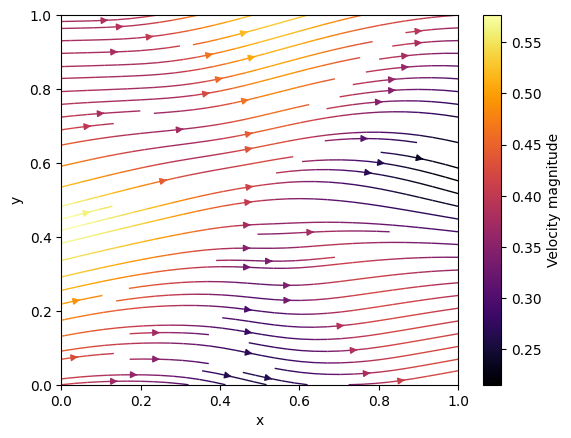

In [30]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

fig, ax = plt.subplots()

velocity_magnitude = np.sqrt(u**2 + v**2)

x_test_grid_2d, y_test_grid_2d = np.meshgrid(x_test, y_test)

strm = ax.streamplot(x_test_grid_2d, y_test_grid_2d, u, v, color=velocity_magnitude, linewidth=1, cmap=cm.inferno)

ax.set_xlim(0, 1)  # Set x-axis limits
ax.set_ylim(0, 1)  # Set y-axis limits
ax.set_xlabel("x")  # Set y-axis limits
ax.set_ylabel("y")  # Set y-axis limits

norm = mcolors.Normalize(vmin=np.min(velocity_magnitude), vmax=np.max(velocity_magnitude))
sm = plt.cm.ScalarMappable(cmap=cm.inferno, norm=norm)
sm.set_array([])

fig.colorbar(sm, ax=ax, label='Velocity magnitude')